In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
from rosbags.highlevel import AnyReader

import numpy as np

In [44]:
def get_pose_data(bag_path, topic_name):
    poses_data = {
        'timestamp': [],
        'time_sec': [],
        'position_x': [],
        'position_y': [],
        'position_z': [],
        'orientation_x': [],
        'orientation_y': [],
        'orientation_z': [],
        'orientation_w': []
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            # Extract pose data
            poses_data['timestamp'].append(timestamp)
            poses_data['time_sec'].append(timestamp / 1e9)

            poses_data['position_x'].append(msg.position.x)
            poses_data['position_y'].append(msg.position.y)
            poses_data['position_z'].append(msg.position.z)

            poses_data['orientation_x'].append(msg.orientation.x)
            poses_data['orientation_y'].append(msg.orientation.y)
            poses_data['orientation_z'].append(msg.orientation.z)
            poses_data['orientation_w'].append(msg.orientation.w)

    poses_data = pd.DataFrame(poses_data)
    
    # clean up time_sec
    # poses_data['time_sec'] = poses_data['time_sec'] - poses_data['time_sec'].min()
    return poses_data

def get_cmd_vel_data(bag_path, topic_name):
    cmd_vel_data = {
        'timestamp': [],
        'time_sec': [],
        'linear_x': [],
        'angular_z': []
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            # Extract pose data
            cmd_vel_data['timestamp'].append(timestamp)
            cmd_vel_data['time_sec'].append(timestamp / 1e9)
            cmd_vel_data['linear_x'].append(msg.linear.x)
            cmd_vel_data['angular_z'].append(msg.angular.z)

    cmd_vel_data = pd.DataFrame(cmd_vel_data)

    # clean up time_sec
    # cmd_vel_data['time_sec'] = cmd_vel_data['time_sec'] - cmd_vel_data['time_sec'].min()

    return cmd_vel_data

def get_force_data(bag_path, topic_name):
    force_data = {
        'timestamp': [],
        'time_sec': [],
        'data': []
    }
    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)
            force_data['timestamp'].append(timestamp)
            force_data['time_sec'].append(timestamp / 1e9)
            force_data['data'].append(msg.data)

    force_data = pd.DataFrame(force_data)

    # clean up time_sec
    # force_data['time_sec'] = force_data['time_sec'] - force_data['time_sec'].min()

    return force_data

def get_payload_pose(bag_path, topic_name):
    payload_poses = {
        'timestamp': [],
        'time_sec': [],
        'position_x': [],
        'position_y': [],
        'position_z': [],
        'orientation_x': [],
        'orientation_y': [],
        'orientation_z': [],
        'orientation_w': [],
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            for t in msg.transforms:
                if t.child_frame_id == 'payload':        
                    # print(t)
                    payload_poses['timestamp'].append(timestamp)
                    payload_poses['time_sec'].append(timestamp / 1e9)

                    payload_poses['position_x'].append(t.transform.translation.x)
                    payload_poses['position_y'].append(t.transform.translation.y)
                    payload_poses['position_z'].append(t.transform.translation.z)

                    payload_poses['orientation_x'].append(t.transform.rotation.x)
                    payload_poses['orientation_y'].append(t.transform.rotation.y)
                    payload_poses['orientation_z'].append(t.transform.rotation.z)
                    payload_poses['orientation_w'].append(t.transform.rotation.w)

    payload_poses = pd.DataFrame(payload_poses)

    return payload_poses

def clean_data(time_series):
    # fix time_sec column
    time_series['time_sec'] = time_series['time_sec'] - \
        time_series['time_sec'].min()

    # fill in null values
    # time_series = time_series.set_index('time_sec')
    # time_series = time_series.interpolate(method='time').reset_index()
    time_series = time_series.interpolate(method='linear')
    
    return time_series

def get_time_series_data(bag_path, data_type):
    # fetch the data from the ros2 bag
    
    if data_type == 'poses':
        ross_data = get_pose_data(bag_path, '/world_ross_pose')
        monica_data = get_pose_data(bag_path, '/world_monica_pose')

    elif data_type == 'force':
        ross_data = get_force_data(bag_path, '/ross/force')
        monica_data = get_force_data(bag_path, '/monica/force')

    else:
        ross_data = get_cmd_vel_data(bag_path, '/ross/cmd_vel')
        monica_data = get_cmd_vel_data(bag_path, '/monica/cmd_vel')

    # save everything to a single dataframe
    time_series_df = pd.merge(
        monica_data,
        ross_data,
        on='time_sec',
        how='outer',
        suffixes=('_monica', '_ross')
    ).sort_values('time_sec').reset_index(drop=True)

    time_series_df = clean_data(time_series_df)

    return time_series_df


def plot_trajectory(timestamps, data, axis, robot_name):
    plt.plot(
        timestamps,
        data,
        '-r'
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel(axis)
    plt.title(f'Trajectory over time for {robot_name}')
    plt.show()

def plot_displacements_over_time(timestamps, monica_poses, ross_poses):
    initial_displacement = 0.86 # cm
    displacements = np.abs(
        monica_poses.values - ross_poses.values
    ) - initial_displacement

    plt.plot(
        timestamps,
        displacements,
        '-r'
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('Displacement over time for monica and ross')
    plt.show()

def plot_forces(timestamps, monica_force_data, ross_force_data):
    plt.plot(
        timestamps,
        monica_force_data,
        '-r'
    )
    plt.plot(
        timestamps,
        ross_force_data,
        '-b'
    )
    plt.legend(['monica', 'ross'])
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('force (N)')
    plt.title('Force readings over time')
    plt.show()

def plot_force_data(timestamps, force_data):
    plt.plot(
        timestamps,
        force_data,
        '-b'
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('force (N)')
    plt.title('Force readings over time')
    plt.show()

def zoom_helper(time_series, start, end):
    return time_series[
        (time_series['time_sec'] >= start) & 
        (time_series['time_sec'] <= end)
    ]

In [45]:
bag_path = Path('../../bags/08-11_admittance/trial_2')
# bag_path = Path('../../bags/exp_1')

time_series = get_time_series_data(bag_path, 'poses')

# time_series.info()

payload_poses = get_payload_pose(bag_path, '/tf')
payload_poses = clean_data(payload_poses)

Bag duration: 35.51 seconds
Message count: 80001
Bag duration: 35.51 seconds
Message count: 80001
Bag duration: 35.51 seconds
Message count: 80001


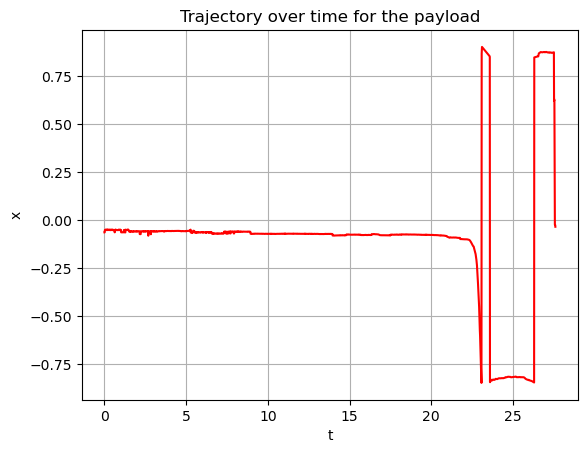

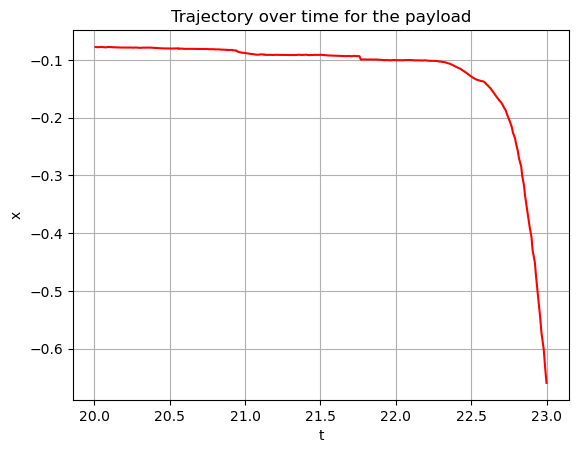

In [46]:
plot_trajectory(payload_poses['time_sec'],
                payload_poses['orientation_x'], 'x', 'the payload')

zoomed_in_df = zoom_helper(payload_poses, 20.0, 23.0)

plot_trajectory(
    zoomed_in_df['time_sec'],
    zoomed_in_df['orientation_x'],
    'x',
    'the payload'
)

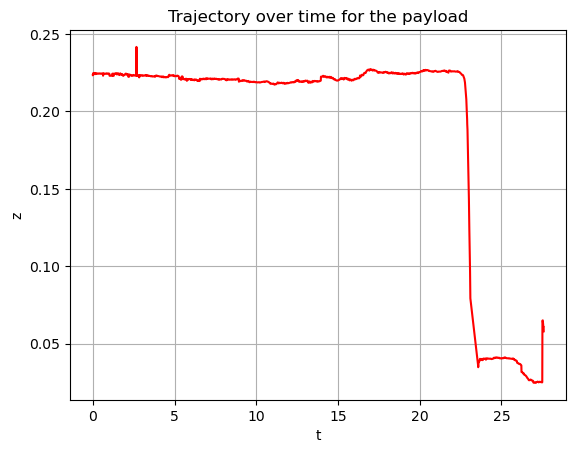

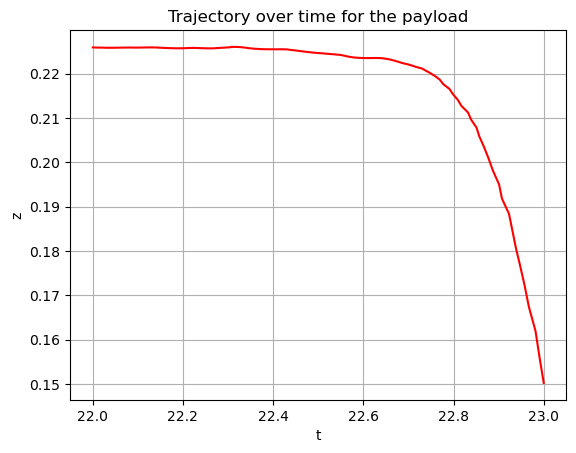

In [47]:
plot_trajectory(payload_poses['time_sec'], payload_poses['position_z'], 'z', 'the payload')

zoomed_in_df = zoom_helper(payload_poses, 22.0, 23.0)

plot_trajectory(
    zoomed_in_df['time_sec'],
    zoomed_in_df['position_z'],
    'z',
    'the payload'
)

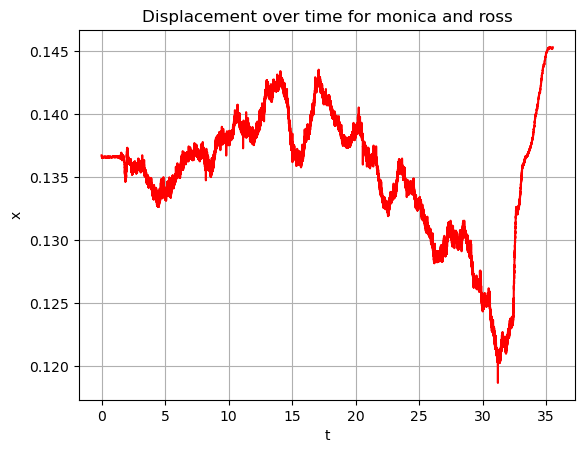

In [48]:
plot_displacements_over_time(
    time_series['time_sec'],
    time_series['position_x_monica'],
    time_series['position_x_ross']
)

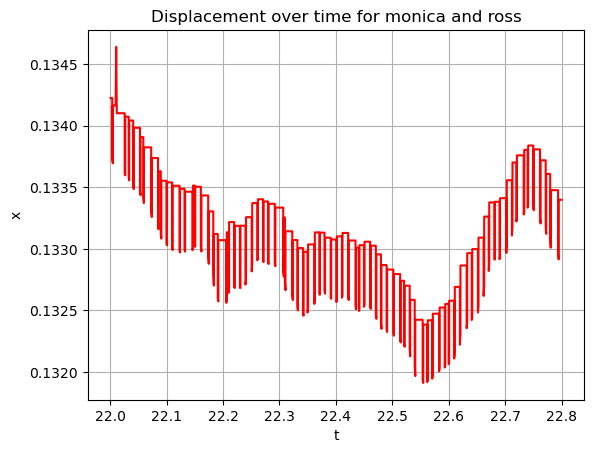

In [49]:
zoomed_in_df = zoom_helper(time_series, 22.0, 22.8)

plot_displacements_over_time(
    zoomed_in_df['time_sec'],
    zoomed_in_df['position_x_monica'],
    zoomed_in_df['position_x_ross']
)

In [50]:
force_time_series = get_time_series_data(bag_path, 'force')

force_time_series.info()

Bag duration: 35.51 seconds
Message count: 80001
Bag duration: 35.51 seconds
Message count: 80001
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2367 entries, 0 to 2366
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp_monica  2367 non-null   float64
 1   time_sec          2367 non-null   float64
 2   data_monica       2367 non-null   float64
 3   timestamp_ross    2366 non-null   float64
 4   data_ross         2366 non-null   float64
dtypes: float64(5)
memory usage: 92.6 KB


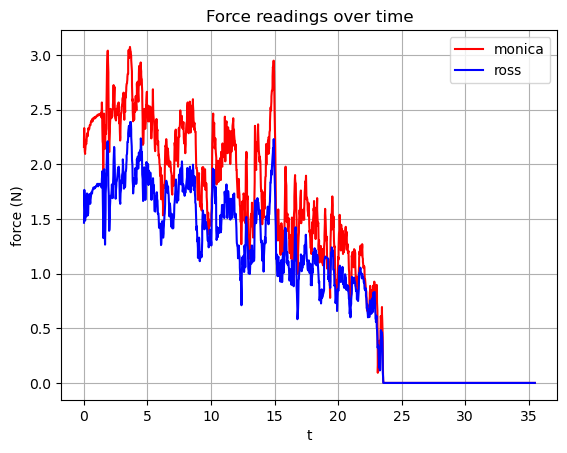

1.2209132611751556
0.9224579655396061


In [51]:
plot_forces(force_time_series['time_sec'], force_time_series['data_monica'], force_time_series['data_ross'])

print(force_time_series['data_monica'].mean())
print(force_time_series['data_ross'].mean())

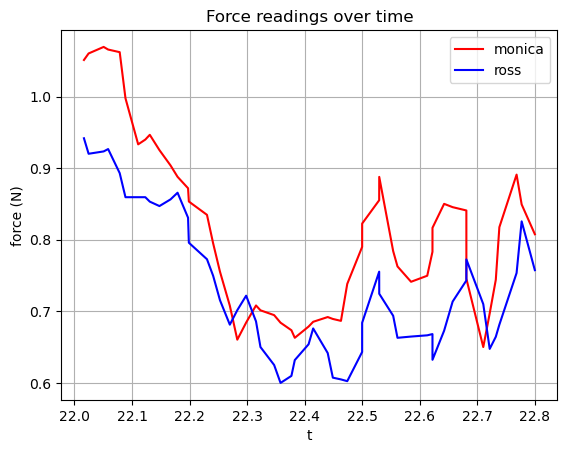

In [52]:
zoomed_in_df = zoom_helper(force_time_series, 22.0, 22.8)

plot_forces(zoomed_in_df['time_sec'],
            zoomed_in_df['data_monica'], 
            zoomed_in_df['data_ross'])

In [53]:
# Determining distance traveled
monica_dist = time_series[
    (time_series['time_sec'] >= 33.4) &
    (time_series['time_sec'] <= 33.41)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

# Determining distance traveled
ross_dist = time_series[
    (time_series['time_sec'] >= 33.4) &
    (time_series['time_sec'] <= 33.41)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

print(f'(Twist started)\nMonica distance traveled: {monica_dist} \nRoss distance traveled: {ross_dist}')

(Twist started)
Monica distance traveled: 3.0486853182315827 
Ross distance traveled: 3.0486853182315827


In [54]:
# Determining distance traveled
monica_dist = time_series[
    (time_series['time_sec'] >= 33.7) &
    (time_series['time_sec'] <= 33.71)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

# Determining distance traveled
ross_dist = time_series[
    (time_series['time_sec'] >= 33.7) &
    (time_series['time_sec'] <= 33.71)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

print(
    f'(Dropped box)\nMonica distance traveled: {monica_dist} \nRoss distance traveled: {ross_dist}')

(Dropped box)
Monica distance traveled: 3.0540800392627716 
Ross distance traveled: 3.0540800392627716


## Modeling out trajectories

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import argparse


def generate_waypoints(x_0, y_0, x_f, y_f, num_waypoints, mag):
    """Generate waypoints with sinusoidal curve"""
    waypoints = []
    t_points = []

    for i in range(num_waypoints):
        progress = i / (num_waypoints - 1)

        # Linear interpolation for base path
        x = x_0 + progress * (x_f - x_0)
        y_base = y_0 + progress * (y_f - y_0)

        # Add quadratic deviation
        y = y_base + mag * progress * progress

        waypoints.append([x, y])
        t_points.append(progress)

    return np.array(waypoints), np.array(t_points)


def create_spline_trajectory(waypoints, t_points, duration):
    """Create cubic spline trajectory from waypoints"""
    # Scale time points to actual duration
    t_scaled = t_points * duration

    # Create splines for x and y
    spline_x = CubicSpline(t_scaled, waypoints[:, 0])
    spline_y = CubicSpline(t_scaled, waypoints[:, 1])

    return spline_x, spline_y


def plot_trajectory(x_0, y_0, x_f, y_f, duration, num_waypoints=5,
                    mag=0.5, num_samples=200):
    """Plot the complete trajectory with waypoints and spline"""

    # Generate waypoints
    waypoints, t_points = generate_waypoints(x_0, y_0, x_f, y_f,
                                             num_waypoints, mag)

    # Create splines
    spline_x, spline_y = create_spline_trajectory(
        waypoints, t_points, duration)

    # Sample the spline for smooth plotting
    t_fine = np.linspace(0, duration, num_samples)
    x_fine = spline_x(t_fine)
    y_fine = spline_y(t_fine)

    # Calculate velocities
    vx_fine = spline_x(t_fine, 1)  # First derivative
    vy_fine = spline_y(t_fine, 1)

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Trajectory in 2D space
    ax1.plot(x_fine, y_fine, 'b-', linewidth=2, label='Spline Trajectory')
    ax1.plot([x_0, x_f], [y_0, y_f], 'k--', alpha=0.5, label='Direct Path')
    ax1.plot(waypoints[:, 0], waypoints[:, 1], 'ro', markersize=8,
             label=f'Waypoints ({num_waypoints})')
    ax1.plot(x_0, y_0, 'go', markersize=10, label='Start')
    ax1.plot(x_f, y_f, 'rs', markersize=10, label='End')

    # Add direction arrows
    arrow_spacing = len(x_fine) // 10
    for i in range(0, len(x_fine), arrow_spacing):
        if i < len(x_fine) - 1:
            dx = x_fine[i+1] - x_fine[i]
            dy = y_fine[i+1] - y_fine[i]
            ax1.arrow(x_fine[i], y_fine[i], dx*3, dy*3,
                      head_width=0.05, head_length=0.05, fc='blue', ec='blue', alpha=0.7)

    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    ax1.set_xlabel('X Position (m)')
    ax1.set_ylabel('Y Position (m)')
    ax1.set_title('Robot Trajectory')
    ax1.legend()

    # Plot 2: Velocity profile
    speed = np.sqrt(vx_fine**2 + vy_fine**2)
    ax2.plot(t_fine, vx_fine, 'r-', label='Velocity X')
    ax2.plot(t_fine, vy_fine, 'g-', label='Velocity Y')
    ax2.plot(t_fine, speed, 'b-', linewidth=2, label='Speed')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Velocity (m/s)')
    ax2.set_title('Velocity Profile')
    ax2.legend()

    plt.tight_layout()

    # Print trajectory statistics
    total_distance = np.sum(np.sqrt(np.diff(x_fine)**2 + np.diff(y_fine)**2))
    direct_distance = np.sqrt((x_f - x_0)**2 + (y_f - y_0)**2)
    max_speed = np.max(speed)
    avg_speed = total_distance / duration

    print(f"\n--- Trajectory Statistics ---")
    print(f"Duration: {duration:.1f} s")
    print(f"Waypoints: {num_waypoints}")
    print(f"Curve amplitude: {mag:.2f} m")
    print(f"Direct distance: {direct_distance:.2f} m")
    print(f"Spline distance: {total_distance:.2f} m")
    print(f"Path efficiency: {direct_distance/total_distance*100:.1f}%")
    print(f"Max speed: {max_speed:.2f} m/s")
    print(f"Average speed: {avg_speed:.2f} m/s")

    return fig


--- Trajectory Statistics ---
Duration: 30.0 s
Waypoints: 8
Curve amplitude: -1.00 m
Direct distance: 3.61 m
Spline distance: 3.21 m
Path efficiency: 112.3%
Max speed: 0.12 m/s
Average speed: 0.11 m/s


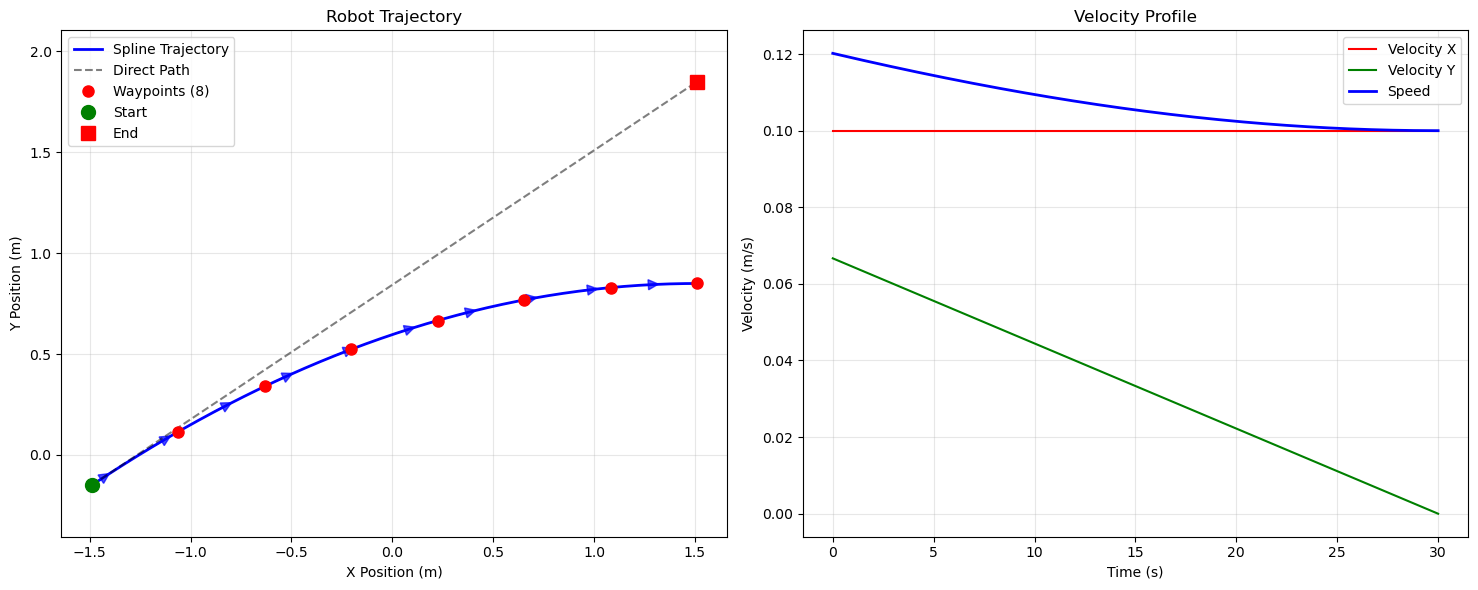

In [60]:
x0 = -1.49
y0 = -0.15
xf = 1.51
yf = 1.85
duration = 30.0
num_waypoints = 8
mag = -1.0

fig = plot_trajectory(x0, y0, xf, yf, duration,
                      num_waypoints, mag)
plt.show()